In [1]:
import tensorflow as tf
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import math
dtype = torch.cuda.FloatTensor
import time

In [0]:
class softmax(nn.Module):
    def __init__(self, W):
        super(softmax, self).__init__()
        self.W = Variable(torch.from_numpy(W).type(dtype), requires_grad=True)

    def forward(self, x, y):
        # calculate loss for the loss function and L2 regularizer
        D = (torch.matmul(x,self.W))
        D_max,_ = torch.max(D,dim = 1, keepdim = True)
        D = D-D_max
        # compute log softmax
        A = torch.log(torch.sum(torch.exp(D),dim = 1))
        B = torch.sum(D*y,dim=1)
        Phi = torch.sum(A-B)
        # L2 regularizer
        W1 = torch.squeeze(self.W)
        L2 = torch.sum(torch.mul(W1, W1))
        return (Phi, L2)

def softmax_np(x):
    e_x = np.exp(x - np.max(x,axis = 1,keepdims = True))
    return e_x / e_x.sum(axis = 1,keepdims = True)


def to_np(x):
    return x.data.cpu().numpy()

# implmentation for backtracking line search
def backtracking_line_search(model,grad,x,y,val,beta,N,lmbd):
    t = 10.0
    beta = 0.5
    W_O = to_np(model.W)
    grad_np = to_np(grad)
    while(True):
        model.W = Variable(torch.from_numpy(W_O-t*grad_np).type(dtype), requires_grad=True)
        val_n = 0.0
        (Phi,L2) = model(x,y)
        val_n = Phi/N + L2*lmbd
        if t < 0.0000000001 :
            print("t too small")
            break
        if to_np(val_n - val + t*torch.norm(grad)**2/2)>=0:
            t = beta *t
        else:
            break

# calculation for softmax in torch, which avoids numerical overflow
def softmax_torch(temp,N):
    max_value,_ = torch.max(temp,1,keepdim = True)
    temp = temp-max_value
    D_exp = torch.exp(temp)
    D_exp_sum = torch.sum(D_exp, dim=1).view(N,1)
    return D_exp.div(D_exp_sum.expand_as(D_exp))

def train(X, Y, model, epoch, lmbd):
    x = Variable(torch.FloatTensor(X).cuda())
    y = Variable(torch.FloatTensor(Y).cuda())
    N = len(Y)
    min_loss = 10000.0
    optimizer = optim.SGD([model.W],lr = 1.0)
    for epoch in range(epoch):
        sum_loss = 0
        phi_loss = 0
        optimizer.zero_grad()
        (Phi,L2) = model(x,y)
        loss = L2*lmbd + Phi/N
        phi_loss += to_np(Phi/N)
        loss.backward()
        temp_W = model.W.data
        grad_loss = to_np(torch.mean(torch.abs(model.W.grad)))
        # save the W with lowest loss
        if grad_loss < min_loss:
            if epoch ==0:
                init_grad = grad_loss
            min_loss = grad_loss
            best_W = temp_W
            if min_loss < init_grad/200:
                print('stopping criteria reached in epoch :{}'.format(epoch))
                break
        backtracking_line_search(model,model.W.grad,x,y,loss,0.5,N,lmbd)
        if epoch % 100 == 0:
            print('Epoch:{:4d}\tloss:{}\tphi_loss:{}\tgrad:{}'.format(epoch, to_np(loss), phi_loss, grad_loss))

    # caluculate w based on the representer theorem's decomposition
    temp = torch.matmul(x,Variable(best_W))
    softmax_value = softmax_torch(temp, N)
    # derivative of softmax cross entropy respect to features, compute alpha
    derivative = softmax_value-y
    alpha = torch.div(derivative,(-2.0*lmbd*N))
    # compute weight
    w = torch.matmul(torch.t(x), alpha)
    # calculate y_p, which is the prediction based on decomposition of w by representer theorem
    temp = torch.matmul(x, w.cuda())
    softmax_value = softmax_torch(temp, N)
    y_p = to_np(softmax_value)

    print('L1 difference between ground truth prediction and prediction by representer theorem decomposition')
    print(np.mean(np.abs(to_np(y)-y_p)))

    from scipy.stats.stats import pearsonr
    print('pearson correlation between ground truth  prediction and prediciton by representer theorem')
    y = to_np(y)
    corr,_ = (pearsonr(y.flatten(),(y_p).flatten()))
    print(corr)
    sys.stdout.flush()
    return to_np(alpha), to_np(softmax_value)

In [0]:
def one_hot(x, zero_index=True):
    if zero_index:
        return np.eye(max(x)+1)[x]
    else:
        return np.eye(max(x))[x]
def normalize(x):
    return (x.astype(np.float32) - 127.5)/127.5
def reverse(x):
    return (x.astype(np.float32)*127.5 + 127.5).astype(np.int32)

In [0]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
(X_train, Y_train), (X_test, Y_test) = (X_train[:10000], Y_train[:10000]), (X_test[:3000], Y_test[:3000]) 

In [0]:
X_train = normalize(X_train)
X_test = normalize(X_test)
# X_train = np.expand_dims(X_train, -1)
# X_test = np.expand_dims(X_test, -1)

In [137]:
Y_train = one_hot(Y_train.flatten())
Y_test = one_hot(Y_test.flatten())
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (10000, 32, 32, 3)
Y_train shape: (10000, 10)
X_test shape: (3000, 32, 32, 3)
Y_test shape: (3000, 10)


In [0]:
def _conv(x, fil_n, ker_n, strides_n, activation=lambda x:x, init=tf.glorot_normal_initializer, pad=None):
    if pad == 'REFLECT':
        p = (ker_n - 1) // 2
        x = tf.pad(x, [[0,0],[p,p],[p,p],[0,0]], 'REFLECT')
        L = tf.layers.conv2d(x, filters=fil_n, kernel_size=ker_n, strides=strides_n, padding='valid', kernel_initializer=init)
    else:
        L=tf.layers.conv2d(x, filters=fil_n, kernel_size=ker_n, strides=strides_n, padding='same', kernel_initializer=init)
    return activation(L)

In [0]:
def accuracy_op(logits, labels):
    correct_prediction = tf.equal(tf.cast(tf.argmax(logits, 1), tf.int32), tf.cast(tf.argmax(labels, 1), tf.int32))
    accuracy = tf.reduce_sum(tf.cast(correct_prediction, tf.int32))
    return accuracy

In [0]:
tf.reset_default_graph()
lam = 0
lr = 1e-2
################################################
sess=tf.Session()
W_predict = tf.get_variable('W_softmax', shape = [4*4*64, 10], initializer = tf.glorot_normal_initializer)
X = tf.placeholder(tf.float32, shape=[None, 32, 32, 3], name = 'X')
Y = tf.placeholder(tf.float32, shape=[None, 10], name = 'Y')


l1 = _conv(X, 256, 3, 2,  activation=tf.nn.relu)
l2 = _conv(l1, 128, 3, 1,  activation=tf.nn.relu)
l3 = _conv(l2, 128, 3, 2,  activation=tf.nn.relu)
l4 = _conv(l3, 64, 3, 1,  activation=tf.nn.relu)
l5 = _conv(l4, 64, 3, 2,  activation=tf.nn.relu)
l6 = _conv(l5, 64, 3, 1,  activation=tf.nn.relu)

feature = tf.reshape(l6, [-1, 4*4*64])
logits = tf.matmul(feature, W_predict)
prob = tf.nn.softmax(logits)


var = tf.trainable_variables() 
lossL2 = tf.add_n([ tf.nn.l2_loss(v) for v in var ]) * lam
cost = tf.losses.softmax_cross_entropy(onehot_labels=Y, logits=logits, label_smoothing=0.1)


train_op = tf.train.AdamOptimizer(lr).minimize(cost+lossL2)


acc = accuracy_op(logits, Y)

sess.run(tf.global_variables_initializer())

In [0]:
batch=len(X_train)//512
epochs=301
for epoch in range(epochs+1):
    epoch_tracc = []
    for i in range(batch):
        batch_xs, batch_ys = X_train[i*512:(i+1)*512], Y_train[i*512:(i+1)*512]
        _, tr_acc =sess.run([train_op, acc], feed_dict={X:batch_xs, Y:batch_ys})  
        epoch_tracc.append(tr_acc/len(batch_xs))
    acc_tr = sum(epoch_tracc)/len(epoch_tracc)
    acc_ts = sess.run(acc, feed_dict={X:X_test, Y:Y_test})
    if epoch%50==0:
      print('Train accuracy: ', np.round(acc_tr,3), ' Test accuracy: ', np.round(acc_ts/len(X_test), 3))

In [0]:
W = sess.run(W_predict)
f = sess.run(feature, feed_dict={X:X_train, Y:Y_train})
model = softmax(W)

In [145]:
alpha, softmax_value = train(f, Y_train, model, 1000, 1e-3)

Epoch:   0	loss:0.548069179058075	phi_loss:0.2636142075061798	grad:0.0006703051622025669
Epoch: 100	loss:0.307928204536438	phi_loss:0.15222102403640747	grad:3.033190114365425e-05
stopping criteria reached in epoch :197
L1 difference between ground truth prediction and prediction by representer theorem decomposition
0.02427931
pearson correlation between ground truth  prediction and prediciton by representer theorem
0.9767308820807805


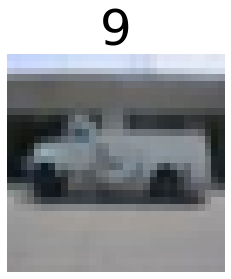

In [157]:
test_index = 110
c = np.argmax(Y_train[test_index])
plt.imshow(reverse(X_train)[test_index])
plt.title('%d' %c, size=50)
plt.axis('off')
plt.show()

In [0]:
feature_ts = sess.run(feature, feed_dict={X:X_train[test_index].reshape(1, 32, 32 ,3)})

# Only one

In [0]:
only_test_class = False
if only_test_class == True:
    rv_list=[]
    for idx in range(len(X_train)):
        if np.argmax(Y_train[idx])==np.argmax(Y_test[test_index]):
            representer_value = alpha[idx,c]*np.sum(f[idx]*feature_ts[0])
            rv_list.append([idx, representer_value])
    order=np.array(sorted(rv_list, key=lambda x: x[1])[::-1])[:,0]
    order=np.asarray(order, dtype=np.int32)
    rv_list= np.array(rv_list)
else:
    representer_value = alpha[:,c]*np.sum(f*feature_ts[0,:], axis=1)
    rv_list = representer_value
    order = np.argsort(representer_value)[::-1]

In [160]:
print(softmax_value[8626,c], alpha[8626,c],np.sum(f[8626]*feature_ts[0]))
print(softmax_value[9876,c], alpha[9876,c],np.sum(f[9876]*feature_ts[0]))

4.0197835e-07 -1.9857382e-08 7.444009
8.650626e-05 -5.406028e-06 2.3680158


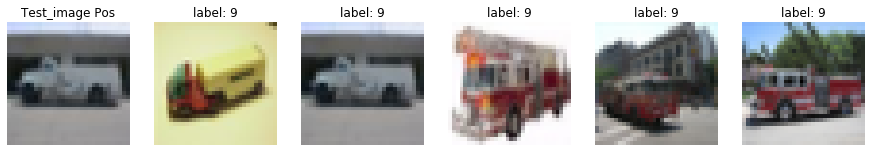

In [161]:
fig = plt.figure(figsize=(18, 8))
for i in range(1, 7):
    ax = plt.subplot(1, 7, i)
    if i == 1:
        plt.imshow(reverse(X_train)[test_index])
        ax.set_title('Test_image Pos')
        ax.axis('off')
    elif i == 2:
        plt.imshow(reverse(X_train)[order][0])
        ax.set_title('label: %d' % np.argmax(Y_train[order[0]]))
        ax.axis('off')
    elif i == 3:
        plt.imshow(reverse(X_train)[order][1])
        ax.axis('off')
        ax.set_title('label: %d' %np.argmax(Y_train[order[1]]))
    elif i == 4:
        plt.imshow(reverse(X_train)[order][2])
        ax.axis('off')
        ax.set_title('label: %d' %np.argmax(Y_train[order[2]]))
    elif i == 5:
        plt.imshow(reverse(X_train)[order][3])
        ax.axis('off')
        ax.set_title('label: %d' %np.argmax(Y_train[order[3]]))
    elif i == 6:
        plt.imshow(reverse(X_train)[order][4])
        ax.axis('off')
        ax.set_title('label: %d' %np.argmax(Y_train[order[4]]))
plt.show()

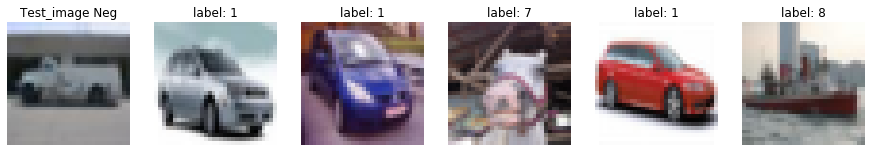

In [162]:
fig = plt.figure(figsize=(18, 8))
for i in range(1, 7):
    ax = plt.subplot(1, 7, i)
    if i == 1:
        plt.imshow(reverse(X_train)[test_index])
        ax.set_title('Test_image Neg')
        ax.axis('off')
    elif i == 2:
        plt.imshow(reverse(X_train)[order][-1])
        ax.set_title('label: %d' %np.argmax(Y_train[order[-1]]))
        ax.axis('off')
    elif i == 3:
        plt.imshow(reverse(X_train)[order][-2])
        ax.axis('off')
        ax.set_title('label: %d' %np.argmax(Y_train[order[-2]]))
    elif i == 4:
        plt.imshow(reverse(X_train)[order][-3])
        ax.axis('off')
        ax.set_title('label: %d' %np.argmax(Y_train[order[-3]]))
    elif i == 5:
        plt.imshow(reverse(X_train)[order][-4])
        ax.axis('off')
        ax.set_title('label: %d' %np.argmax(Y_train[order[-4]]))
    elif i == 6:
        plt.imshow(reverse(X_train)[order][-5])
        ax.axis('off')
        ax.set_title('label: %d' %np.argmax(Y_train[order[-5]]))
plt.show()